# Importing necessary libraries and stock data

In [10]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pandas as pd
import numpy as np
from IPython.display import display
import time

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb

from keras.layers import *
from keras.models import Sequential, Model

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

import warnings
warnings.filterwarnings('ignore')

In [7]:

# Define Date Ranges
start_date = '2005-01-01'
end_date = '2020-12-31'

# Fetch the stock data
ticker_symbol = 'GOOG'
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the data
print(stock_data)


[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2005-01-03   4.916571   5.071989   4.868253   5.048826   5.043087  636143518
2005-01-04   5.016198   5.054305   4.818937   4.844342   4.838836  552298420
2005-01-05   4.818190   4.904118   4.787804   4.819685   4.814207  330698912
2005-01-06   4.858788   4.879212   4.675475   4.696148   4.690810  417041336
2005-01-07   4.748203   4.838116   4.701876   4.828153   4.822665  387964757
...               ...        ...        ...        ...        ...        ...
2020-12-23  86.405502  87.399498  86.251999  86.619003  86.520546   20676000
2020-12-24  86.750000  87.300003  86.455498  86.942497  86.843674    6936000
2020-12-28  87.581749  89.536400  87.316750  88.804497  88.703560   27860000
2020-12-29  89.389503  89.622002  87.804497  87.935997  87.836044   25988000
2020-12-30  88.100502  88.254753  86.279999  86.975998  86.877136   26122000

# Building baseline model using regression

In [8]:
df = stock_data.copy()

#EMA 
ema = df['Adj Close'].ewm(com=0.8).mean()
df['EMA'] = ema

#High-Low (volatility indicator)
high_low=df['High']-df['Low']
df['high_low']=high_low

#RSI (14-day)
change = df["Adj Close"].diff()
change.dropna(inplace=True)
change_up = change.copy()
change_down = change.copy()
change_up[change_up<0] = 0
change_down[change_down>0] = 0
change.equals(change_up+change_down)
avg_up = change_up.rolling(14).mean()
avg_down = change_down.rolling(14).mean().abs()
rsi = 100 * avg_up / (avg_up + avg_down)
df['RSI'] = rsi
df.RSI=df.RSI.fillna(df.RSI.median())

#VWAP
df['VWAP'] = (df['Volume'] * (df['High'] + df['Low'] + df['Close']) / 3).cumsum() / df['Volume'].cumsum()

print(df)


                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2005-01-03   4.916571   5.071989   4.868253   5.048826   5.043087  636143518   
2005-01-04   5.016198   5.054305   4.818937   4.844342   4.838836  552298420   
2005-01-05   4.818190   4.904118   4.787804   4.819685   4.814207  330698912   
2005-01-06   4.858788   4.879212   4.675475   4.696148   4.690810  417041336   
2005-01-07   4.748203   4.838116   4.701876   4.828153   4.822665  387964757   
...               ...        ...        ...        ...        ...        ...   
2020-12-23  86.405502  87.399498  86.251999  86.619003  86.520546   20676000   
2020-12-24  86.750000  87.300003  86.455498  86.942497  86.843674    6936000   
2020-12-28  87.581749  89.536400  87.316750  88.804497  88.703560   27860000   
2020-12-29  89.389503  89.622002  87.804497  87.935997  87.836044   25988000   
2020-12-30  88.100502  88.254753  86.279

In [9]:
data=df.copy()
print(data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'EMA',
       'high_low', 'RSI', 'VWAP'],
      dtype='object')


In [11]:
# Feature engineering: Create lag features
data['Open_Lag1'] = data['Open'].shift(1)
data['Close_Lag1'] = data['Close'].shift(1)
data['High_Lag1'] = data['High'].shift(1)
data['Low_Lag1'] = data['Low'].shift(1)
data['Volume_Lag1'] = data['Volume'].shift(1)
data['EMA_Lag1'] = data['EMA'].shift(1)
data['high_low_Lag1'] = data['high_low'].shift(1)
data['RSI_Lag1'] = data['RSI'].shift(1)
data['VWAP_Lag1'] = data['VWAP'].shift(1)

# Drop rows with missing values due to lagging
data.dropna(inplace=True)

# Define features and target
features = [
    'Open_Lag1', 'High_Lag1', 'Low_Lag1', 'Close_Lag1', 'Adj Close', 'Volume_Lag1', 
    'EMA_Lag1', 'high_low_Lag1', 'RSI_Lag1', 'VWAP_Lag1'
]
target = 'Close'

X = data[features]
y = data[target]

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize regression models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

# Evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = (mse, y_pred)
    print(f'{name} - Mean Squared Error: {mse}')


Linear Regression - Mean Squared Error: 6.555170453517973e-13
Ridge Regression - Mean Squared Error: 3.223155617583136e-07
Lasso Regression - Mean Squared Error: 0.0988819330934781
Random Forest - Mean Squared Error: 0.00794298077489185
Gradient Boosting - Mean Squared Error: 0.02006069470522828
XGBoost - Mean Squared Error: 0.020884869779518443


# Building improved model using LSTM

In [20]:
train_data=df.copy()
scaler = MinMaxScaler()
train_data[train_data.columns] = scaler.fit_transform(train_data[train_data.columns])
train_data

,Open,High,Low,Close,Adj Close,Volume,EMA,high_low,RSI,VWAP
Date,,,,,,,,,,
2005-01-03,0.006337,0.007150,0.006566,0.007932,0.007932,0.385288,0.007488,0.031907,0.530478,0.022210
2005-01-04,0.007484,0.006949,0.005998,0.005583,0.005583,0.334494,0.005857,0.038122,0.530478,0.018309
2005-01-05,0.005204,0.005241,0.005639,0.005299,0.005299,0.200246,0.005242,0.014730,0.530478,0.015944
2005-01-06,0.005672,0.004958,0.004345,0.003880,0.003880,0.252553,0.004191,0.031907,0.530478,0.012376
2005-01-07,0.004399,0.004490,0.004649,0.005397,0.005397,0.234938,0.004617,0.018645,0.530478,0.010812
...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.944503,0.943577,0.943795,0.945078,0.945078,0.012430,0.946919,0.217340,0.165739,0.998885
2020-12-24,0.948469,0.942446,0.946139,0.948794,0.948794,0.004106,0.949175,0.157807,0.192588,0.998973
2020-12-28,0.958045,0.967883,0.956057,0.970186,0.970187,0.016782,0.962095,0.428000,0.360310,0.999333


In [22]:
prediction_time=1
test_data_size=500 
unroll_length=50

test_data_cut = test_data_size + unroll_length + 1

x_train = train_data[0:-prediction_time - test_data_cut].values
y_train = train_data[prediction_time:-test_data_cut]['Close'].values

# test data
x_test = train_data[0 - test_data_cut:-prediction_time].values
y_test = train_data[prediction_time - test_data_cut:]['Close'].values

x_train.shape, x_test.shape, y_train.shape, y_test.shape


((3475, 10), (550, 10), (3475,), (550,))

In [23]:
def unroll(data, sequence_length=24):
    """
    use different windows for testing and training to stop from leak of information in the data
    :param data: data set to be used for unrolling
    :param sequence_length: window length
    :return: data sets with different window.
    """
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

x_train = unroll(x_train, unroll_length)
x_test = unroll(x_test, unroll_length)


In [25]:
y_train = y_train[-x_train.shape[0]:]
y_test = y_test[-x_test.shape[0]:]
x_train, x_test, y_train, y_test

(array([[[6.33705836e-03, 7.15045387e-03, 6.56552526e-03, ...,
          3.19070794e-02, 5.30477970e-01, 2.22104129e-02],
         [7.48404403e-03, 6.94930901e-03, 5.99758872e-03, ...,
          3.81223075e-02, 5.30477970e-01, 1.83086397e-02],
         [5.20441735e-03, 5.24102047e-03, 5.63905901e-03, ...,
          1.47301785e-02, 5.30477970e-01, 1.59436511e-02],
         ...,
         [1.47386613e-03, 7.22409742e-04, 1.31367176e-03, ...,
          1.04726095e-02, 2.05533126e-01, 4.97945485e-03],
         [8.68837542e-04, 0.00000000e+00, 0.00000000e+00, ...,
          2.04067809e-02, 2.32935485e-01, 4.23882446e-03],
         [0.00000000e+00, 4.53278296e-04, 4.70388348e-04, ...,
          2.02112492e-02, 2.55165035e-01, 3.65738556e-03]],
 
        [[7.48404403e-03, 6.94930901e-03, 5.99758872e-03, ...,
          3.81223075e-02, 5.30477970e-01, 1.83086397e-02],
         [5.20441735e-03, 5.24102047e-03, 5.63905901e-03, ...,
          1.47301785e-02, 5.30477970e-01, 1.59436511e-02],
       

In [26]:
def build_basic_model(input_dim, output_dim, return_sequences):
    """
    Builds a basic lstm model 
    :param input_dim: input dimension of the model
    :param output_dim: output dimension of the model
    :param return_sequences: return sequence of the model
    :return: a basic lstm model with 3 layers.
    """
    model = Sequential()
    model.add(LSTM(
        input_shape=(None, input_dim),
        units=output_dim,
        return_sequences=return_sequences))

    model.add(LSTM(
        100,
        return_sequences=False))

    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    return model

In [27]:

model = build_basic_model(input_dim = x_train.shape[-1],output_dim = unroll_length, return_sequences=True)
start = time.time() 
model.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : ', time.time() - start)


compilation time :  0.020691633224487305


In [28]:
model.fit(
    x_train,
    y_train,
    epochs=5,
    validation_split=0.05)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 0.0043 - val_loss: 5.2059e-04
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 8.5043e-05 - val_loss: 6.3057e-04
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 7.7041e-05 - val_loss: 0.0010
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 8.2564e-05 - val_loss: 9.6635e-04
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 7.1172e-05 - val_loss: 3.9667e-04


In [29]:
def plot_lstm_prediction(actual, prediction, title='Google Trading vs Prediction', y_label='Price USD', x_label='Trading Days'):
    """
    Plots train, test and prediction
    :param actual: DataFrame containing actual data
    :param prediction: DataFrame containing predicted values
    :param title:  Title of the plot
    :param y_label: yLabel of the plot
    :param x_label: xLabel of the plot
    :return: prints a Pyplot againts items and their closing value
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    # Plot actual and predicted close values

    plt.plot(actual, '#00FF00', label='Adjusted Close')
    plt.plot(prediction, '#0000FF', label='Predicted Close')

    # Set title
    ax.set_title(title)
    ax.legend(loc='upper left')


    plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


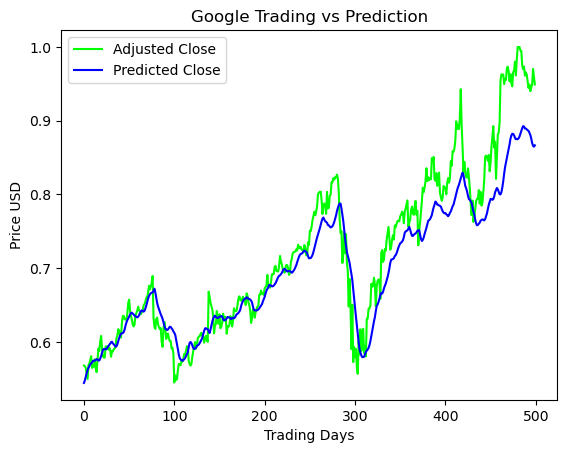

In [30]:
predictions = model.predict(x_test)
plot_lstm_prediction(y_test,predictions)

In [31]:
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00010304 MSE (0.01015086 RMSE)
Test Score: 0.00191038 MSE (0.04370786 RMSE)


In [32]:
def build_improved_model(input_dim, output_dim, return_sequences):
    """
    Builds an improved Long Short term memory model using keras.layers.recurrent.lstm
    :param input_dim: input dimension of model
    :param output_dim: ouput dimension of model
    :param return_sequences: return sequence for the model
    :return: a 3 layered LSTM model
    """
    model = Sequential()
    model.add(LSTM(
        input_shape=(None, input_dim),
        units=output_dim,
        return_sequences=return_sequences))

    model.add(Dropout(0.2))

    model.add(LSTM(
        128,
        return_sequences=False))

    model.add(Dropout(0.2))

    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    return model

In [33]:
batch_size = 100
epochs = 8
batch_size = 100
epochs = 5

# build improved lstm model
model_imp = build_improved_model( x_train.shape[-1],output_dim = unroll_length, return_sequences=True)

start = time.time()
model_imp.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : ', time.time() - start)

compilation time :  0.005003452301025391


In [35]:
model_imp.fit(x_train, 
          y_train, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split=0.05
         )

Epoch 1/5
33/33 - 9s - 274ms/step - loss: 0.0059 - val_loss: 0.0038
Epoch 2/5
33/33 - 5s - 155ms/step - loss: 6.4873e-04 - val_loss: 5.8926e-04
Epoch 3/5
33/33 - 5s - 164ms/step - loss: 5.2165e-04 - val_loss: 7.2631e-04
Epoch 4/5
33/33 - 10s - 289ms/step - loss: 4.7698e-04 - val_loss: 5.8435e-04
Epoch 5/5
33/33 - 4s - 136ms/step - loss: 4.1148e-04 - val_loss: 5.8931e-04


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


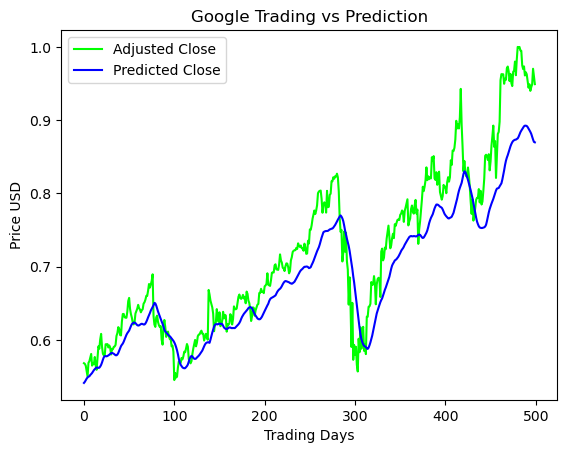

In [36]:
predictions = model_imp.predict(x_test, batch_size=batch_size)
plot_lstm_prediction(y_test,predictions)

In [37]:
trainScore = model_imp.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model_imp.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00010601 MSE (0.01029600 RMSE)
Test Score: 0.00242249 MSE (0.04921878 RMSE)
